In [ ]:
!pip install prophet dagshub scikit-learn pandas numpy mlflow==2.2.2

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import mlflow
import mlflow.sklearn
import dagshub
import os
import pickle
from datetime import datetime

warnings.filterwarnings('ignore')

In [ ]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'nipkha21'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '202fb8a4c58a90b0eb3598b1037498eb6fe9f593'

dagshub.init(repo_owner='TomC333', repo_name='ml-walmart-recruiting', mlflow=True)
mlflow.set_tracking_uri('https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow')

print("MLflow setup completed")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=63e56969-a1c1-49b6-9c15-4a2498478c29&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=11d02572b7aa0e277f3383aee8155ee330fe201c2effdd3be967ca013ce723c4




Accessing as nipkha21

Initialized MLflow to track repo "TomC333/ml-walmart-recruiting"

Repository TomC333/ml-walmart-recruiting initialized!

MLflow setup completed


In [ ]:
model_name = "SARIMA_Sales_Forecasting"
print(f"Loading SARIMA model from MLflow...")

try:
    latest_version = mlflow.get_latest_versions(model_name, stages=["None"])[0]
    run_id = latest_version.run_id
    print(f"Found model version {latest_version.version} from run: {run_id}")
except Exception as e:
    print(f"Error getting latest version: {e}")
    run_id = "f7c4dba37ff54a50906c1785b1b488f4"
    print(f"Using specific run_id: {run_id}")

try:
    preprocessing_config = mlflow.artifacts.load_dict(f"runs:/{run_id}/preprocessing_config.json")
    print("✅ Loaded preprocessing config")
except Exception as e:
    print(f"Could not load preprocessing config: {e}")
    preprocessing_config = {
        "min_data_points": 20,
        "train_ratio": 0.8,
        "remove_negative_sales": True,
        "holiday_dates": {
            "superbowl": ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
            "laborday": ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
            "thanksgiving": ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
            "christmas": ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
        },
        "external_cols": ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
        "sarima_params": {
            "order": (1, 1, 1),
            "seasonal_order": (1, 1, 1, 52),
            "auto_params": False
        }
    }

try:
    model_config = mlflow.artifacts.load_dict(f"runs:/{run_id}/model_config.json")
    print(f"✅ Loaded model config: {model_config['best_phase']}")
    best_order = model_config['order']
    best_seasonal_order = model_config['seasonal_order']
    best_exog_vars = model_config['exog_vars']
    auto_params = model_config['auto_params']
except Exception as e:
    print(f"Could not load model config: {e}")
    best_order = (1, 1, 1)
    best_seasonal_order = (1, 1, 1, 52)
    best_exog_vars = None
    auto_params = False
    print("Using basic SARIMA configuration")

print(f"Configuration loaded:")
print(f"  Order: {best_order}")
print(f"  Seasonal Order: {best_seasonal_order}")
print(f"  Exogenous Variables: {best_exog_vars}")
print(f"  Auto Parameters: {auto_params}")

Loading SARIMA model from MLflow...
Error getting latest version: module 'mlflow' has no attribute 'get_latest_versions'
Using specific run_id: f7c4dba37ff54a50906c1785b1b488f4
✅ Loaded preprocessing config
✅ Loaded model config: Phase2_SARIMA_NoMA
Configuration loaded:
  Order: [1, 1, 0]
  Seasonal Order: [1, 1, 0, 52]
  Exogenous Variables: None
  Auto Parameters: False


In [ ]:
def check_stationarity(timeseries, title):
    """Check if time series is stationary using ADF test"""
    result = adfuller(timeseries.dropna())
    print(f'\nStationarity Test for {title}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')

    if result[1] <= 0.05:
        print("Result: Time series is stationary")
        return True
    else:
        print("Result: Time series is non-stationary")
        return False

def smart_sarima_order(ts, quick_search=True):
    """Smart SARIMA parameter selection - much faster"""
    if quick_search:
        param_combinations = [
            ((1,1,1), (1,1,1,52)),
            ((1,1,0), (1,1,0,52)),
            ((0,1,1), (0,1,1,52)),
            ((1,1,1), (0,1,1,52)),
            ((2,1,1), (1,1,1,52)),
            ((1,1,2), (1,1,1,52)),
        ]
    else:
        pass

    best_aic = np.inf
    best_order = (1,1,1)
    best_seasonal_order = (1,1,1,52)

    for order, seasonal_order in param_combinations:
        try:
            model = SARIMAX(ts, order=order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
            fitted_model = model.fit(disp=False)

            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

    return best_order, best_seasonal_order, best_aic

def fit_sarima_model(ts, order, seasonal_order, exog=None):
    """Fit SARIMA model with given parameters"""
    try:
        model = SARIMAX(ts, order=order, seasonal_order=seasonal_order,
                       exog=exog, enforce_stationarity=False, enforce_invertibility=False)
        fitted_model = model.fit(disp=False)
        return fitted_model
    except Exception as e:
        print(f"Error fitting SARIMA model: {e}")
        return None

print("✅ SARIMA helper functions defined")

✅ SARIMA helper functions defined


In [ ]:
def create_preprocessing_pipeline(config):
    """Create preprocessing pipeline matching the training process"""

    def preprocess_data(features_data, train_data, stores_data, is_test_data=False):
        if is_test_data:
            df = train_data.merge(features_data, on=['Store', 'Date'], how='left').merge(stores_data, on=['Store'], how='left')
        else:
            df = train_data.merge(features_data, on=['Store', 'Date'], how='inner').merge(stores_data, on=['Store'], how='inner')

        if 'IsHoliday_y' in df.columns:
            df.drop(['IsHoliday_y'], axis=1, inplace=True)
            df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(['Store', 'Dept', 'Date'])

        if config.get("remove_negative_sales", False) and not is_test_data:
            if 'Weekly_Sales' in df.columns:
                df = df[df['Weekly_Sales'] >= 0]

        holiday_dates = config.get("holiday_dates", {})
        df['Is_SuperBowl'] = np.where(df['Date'].isin(pd.to_datetime(holiday_dates.get('superbowl', []))), 1, 0)
        df['Is_LaborDay'] = np.where(df['Date'].isin(pd.to_datetime(holiday_dates.get('laborday', []))), 1, 0)
        df['Is_Thanksgiving'] = np.where(df['Date'].isin(pd.to_datetime(holiday_dates.get('thanksgiving', []))), 1, 0)
        df['Is_Christmas'] = np.where(df['Date'].isin(pd.to_datetime(holiday_dates.get('christmas', []))), 1, 0)

        external_cols = config.get("external_cols", [])
        for col in external_cols:
            if col in df.columns:
                df[col] = df.groupby(['Store', 'Dept'])[col].ffill().bfill()

        return df

    return preprocess_data

preprocess_fn = create_preprocessing_pipeline(preprocessing_config)
print("✅ Preprocessing pipeline created")

print("Loading raw data...")
features_data = pd.read_csv('features.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
stores_data = pd.read_csv('stores.csv')

print(f"Features: {features_data.shape}")
print(f"Train: {train_data.shape}")
print(f"Test: {test_data.shape}")
print(f"Stores: {stores_data.shape}")

processed_train = preprocess_fn(features_data, train_data, stores_data)
print(f"Processed training data: {processed_train.shape}")

test_df = test_data.merge(features_data, on=['Store', 'Date'], how='left').merge(stores_data, on=['Store'], how='left')
if 'IsHoliday_y' in test_df.columns:
    test_df.drop(['IsHoliday_y'], axis=1, inplace=True)
    test_df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

test_df['Date'] = pd.to_datetime(test_df['Date'])

test_df = preprocess_fn(features_data, test_data, stores_data, is_test_data=True)
print(f"Test data prepared: {test_df.shape}")

print("✅ Data loading completed")

✅ Preprocessing pipeline created
Loading raw data...
Features: (8190, 12)
Train: (421570, 5)
Test: (115064, 4)
Stores: (45, 3)
Processed training data: (420285, 20)
Test data prepared: (115064, 19)
✅ Data loading completed


In [ ]:
def prepare_sarima_inference_data(train_data, test_data, store, dept, exog_vars=None):
    """Prepare SARIMA data for a specific store-department combination"""
    store_dept_train = train_data[(train_data['Store'] == store) & (train_data['Dept'] == dept)].sort_values('Date')
    store_dept_test = test_data[(test_data['Store'] == store) & (test_data['Dept'] == dept)].sort_values('Date')

    if len(store_dept_train) < preprocessing_config['min_data_points']:
        return None, None, None, None

    train_ts = store_dept_train.set_index('Date')['Weekly_Sales']

    train_exog = None
    test_exog = None

    if exog_vars:
        available_vars = [var for var in exog_vars if var in store_dept_train.columns]
        if available_vars:
            train_exog = store_dept_train.set_index('Date')[available_vars]
            if len(store_dept_test) > 0:
                test_exog = store_dept_test.set_index('Date')[available_vars]

    return train_ts, train_exog, test_exog, store_dept_test

def train_and_predict_sarima(train_ts, train_exog, test_exog, test_dates, order, seasonal_order, auto_params=False):
    """Train SARIMA model and make predictions"""
    try:
        if auto_params:
          try:
              order, seasonal_order, aic = smart_sarima_order(train_ts, quick_search=True)
          except:
              pass

        fitted_model = fit_sarima_model(train_ts, order, seasonal_order, train_exog)
        if fitted_model is None:
            return None

        if test_exog is not None:
            forecast = fitted_model.forecast(steps=len(test_dates), exog=test_exog)
        else:
            forecast = fitted_model.forecast(steps=len(test_dates))

        forecast = np.maximum(forecast, 0)

        return forecast.values

    except Exception as e:
        print(f"Error in SARIMA prediction: {e}")
        return None

print("✅ SARIMA inference functions defined")

✅ SARIMA inference functions defined


In [ ]:
def make_all_predictions_sarima(train_data, test_data, order, seasonal_order, exog_vars=None, auto_params=False):
    """Make SARIMA predictions for all store-department combinations"""

    test_combinations = test_data[['Store', 'Dept']].drop_duplicates()

    top_stores = processed_train.groupby('Store')['Weekly_Sales'].sum().nlargest(20).index
    test_combinations = test_combinations[test_combinations['Store'].isin(top_stores)]

    test_combinations = test_combinations.sample(n=500, random_state=42)

    print(f"Reduced to {len(test_combinations)} combinations")

    predictions = {}
    successful_predictions = 0
    failed_predictions = 0

    for idx, row in test_combinations.iterrows():
        store, dept = row['Store'], row['Dept']

        train_ts, train_exog, test_exog, test_subset = prepare_sarima_inference_data(
            train_data, test_data, store, dept, exog_vars
        )

        if train_ts is None:
            global_median = train_data['Weekly_Sales'].median()
            test_subset = test_data[(test_data['Store'] == store) & (test_data['Dept'] == dept)]
            for _, test_row in test_subset.iterrows():
                key = f"{int(test_row['Store'])}_{int(test_row['Dept'])}_{test_row['Date'].strftime('%Y-%m-%d')}"
                predictions[key] = global_median
            failed_predictions += 1
            continue

        pred_values = train_and_predict_sarima(
            train_ts, train_exog, test_exog, test_subset, order, seasonal_order, auto_params
        )

        if pred_values is not None and len(pred_values) > 0:
            for i, (_, test_row) in enumerate(test_subset.iterrows()):
                if i < len(pred_values):
                    key = f"{int(test_row['Store'])}_{int(test_row['Dept'])}_{test_row['Date'].strftime('%Y-%m-%d')}"
                    predictions[key] = pred_values[i]
            successful_predictions += 1
        else:
            global_median = train_data['Weekly_Sales'].median()
            for _, test_row in test_subset.iterrows():
                key = f"{int(test_row['Store'])}_{int(test_row['Dept'])}_{test_row['Date'].strftime('%Y-%m-%d')}"
                predictions[key] = global_median
            failed_predictions += 1

        if (successful_predictions + failed_predictions) % 50 == 0:
            print(f"Processed {successful_predictions + failed_predictions} combinations...")

    print(f"\nSARIMA Prediction generation completed:")
    print(f"Successful predictions: {successful_predictions}")
    print(f"Failed predictions (using fallback): {failed_predictions}")
    print(f"Total predictions generated: {len(predictions)}")

    return predictions

print("✅ Prediction functions defined")

✅ Prediction functions defined


In [ ]:
print("Starting SARIMA predictions...")
print(f"Using configuration:")
print(f"  Order: {best_order}")
print(f"  Seasonal Order: {best_seasonal_order}")
print(f"  Exogenous Variables: {best_exog_vars}")
print(f"  Auto Parameters: {auto_params}")

predictions = make_all_predictions_sarima(
    processed_train,
    test_df,
    best_order,
    best_seasonal_order,
    best_exog_vars,
    auto_params
)

Starting SARIMA predictions...
Using configuration:
  Order: [1, 1, 0]
  Seasonal Order: [1, 1, 0, 52]
  Exogenous Variables: None
  Auto Parameters: False
Reduced to 500 combinations
Processed 50 combinations...
Processed 100 combinations...
Processed 150 combinations...
Processed 200 combinations...
Processed 250 combinations...
Processed 300 combinations...
Processed 350 combinations...
Processed 400 combinations...
Processed 450 combinations...
Processed 500 combinations...

SARIMA Prediction generation completed:
Successful predictions: 484
Failed predictions (using fallback): 16
Total predictions generated: 18539


In [ ]:
if len(predictions) > 0:
    submission_data = []
    for key, prediction in predictions.items():
        submission_data.append({
            'Id': key,
            'Weekly_Sales': prediction
        })

    submission_df = pd.DataFrame(submission_data)
    print(f"Submission dataframe created with {len(submission_df)} rows")

    print("SARIMA Prediction statistics:")
    print(f"Mean prediction: {submission_df['Weekly_Sales'].mean():.2f}")
    print(f"Median prediction: {submission_df['Weekly_Sales'].median():.2f}")
    print(f"Min prediction: {submission_df['Weekly_Sales'].min():.2f}")
    print(f"Max prediction: {submission_df['Weekly_Sales'].max():.2f}")
    print(f"Std prediction: {submission_df['Weekly_Sales'].std():.2f}")

    submission_df.to_csv('sarima_submission.csv', index=False)
    print("✅ SARIMA submission saved as 'sarima_submission.csv'")

    print("\nFirst 10 SARIMA predictions:")
    print(submission_df.head(10))

    print(f"\n📊 COMPREHENSIVE MODEL COMPARISON:")

    try:
        prophet_submission = pd.read_csv('prophet_submission.csv')
        print(f"Prophet - Mean: {prophet_submission['Weekly_Sales'].mean():.2f}, Median: {prophet_submission['Weekly_Sales'].median():.2f}")
    except FileNotFoundError:
        print("Prophet - Mean: 16763, Median: 7815 (from previous results)")

    try:
        nbeats_submission = pd.read_csv('nbeats_submission.csv')
        print(f"N-BEATS - Mean: {nbeats_submission['Weekly_Sales'].mean():.2f}, Median: {nbeats_submission['Weekly_Sales'].median():.2f}")
    except FileNotFoundError:
        print("N-BEATS - Mean: 8507, Median: 4468 (from previous results)")

    print(f"SARIMA  - Mean: {submission_df['Weekly_Sales'].mean():.2f}, Median: {submission_df['Weekly_Sales'].median():.2f}")

    print(f"\n📈 PREDICTION RANGE ANALYSIS:")
    prophet_median = 7815
    nbeats_median = 4468
    sarima_median = submission_df['Weekly_Sales'].median()

    print(f"Prophet median: {prophet_median}")
    print(f"N-BEATS median: {nbeats_median}")
    print(f"SARIMA median:  {sarima_median:.0f}")

    if sarima_median < nbeats_median:
        print("→ SARIMA predicts lower than N-BEATS")
    if sarima_median < prophet_median:
        print("→ SARIMA predicts lower than Prophet")

else:
    print("❌ No predictions generated")

Submission dataframe created with 18539 rows
SARIMA Prediction statistics:
Mean prediction: 3018261.33
Median prediction: 13457.90
Min prediction: 0.00
Max prediction: 18259677252.74
Std prediction: 180837302.54
✅ SARIMA submission saved as 'sarima_submission.csv'

First 10 SARIMA predictions:
                 Id  Weekly_Sales
0  18_91_2012-11-02  24840.592013
1  18_91_2012-11-09  25783.990460
2  18_91_2012-11-16  24510.166377
3  18_91_2012-11-23  22936.433943
4  18_91_2012-11-30  24746.431103
5  18_91_2012-12-07  25576.207546
6  18_91_2012-12-14  24045.045940
7  18_91_2012-12-21  24365.006614
8  18_91_2012-12-28  23016.854456
9  18_91_2013-01-04  27751.723129

📊 COMPREHENSIVE MODEL COMPARISON:
Prophet - Mean: 16763, Median: 7815 (from previous results)
N-BEATS - Mean: 8507, Median: 4468 (from previous results)
SARIMA  - Mean: 3018261.33, Median: 13457.90

📈 PREDICTION RANGE ANALYSIS:
Prophet median: 7815
N-BEATS median: 4468
SARIMA median:  13458


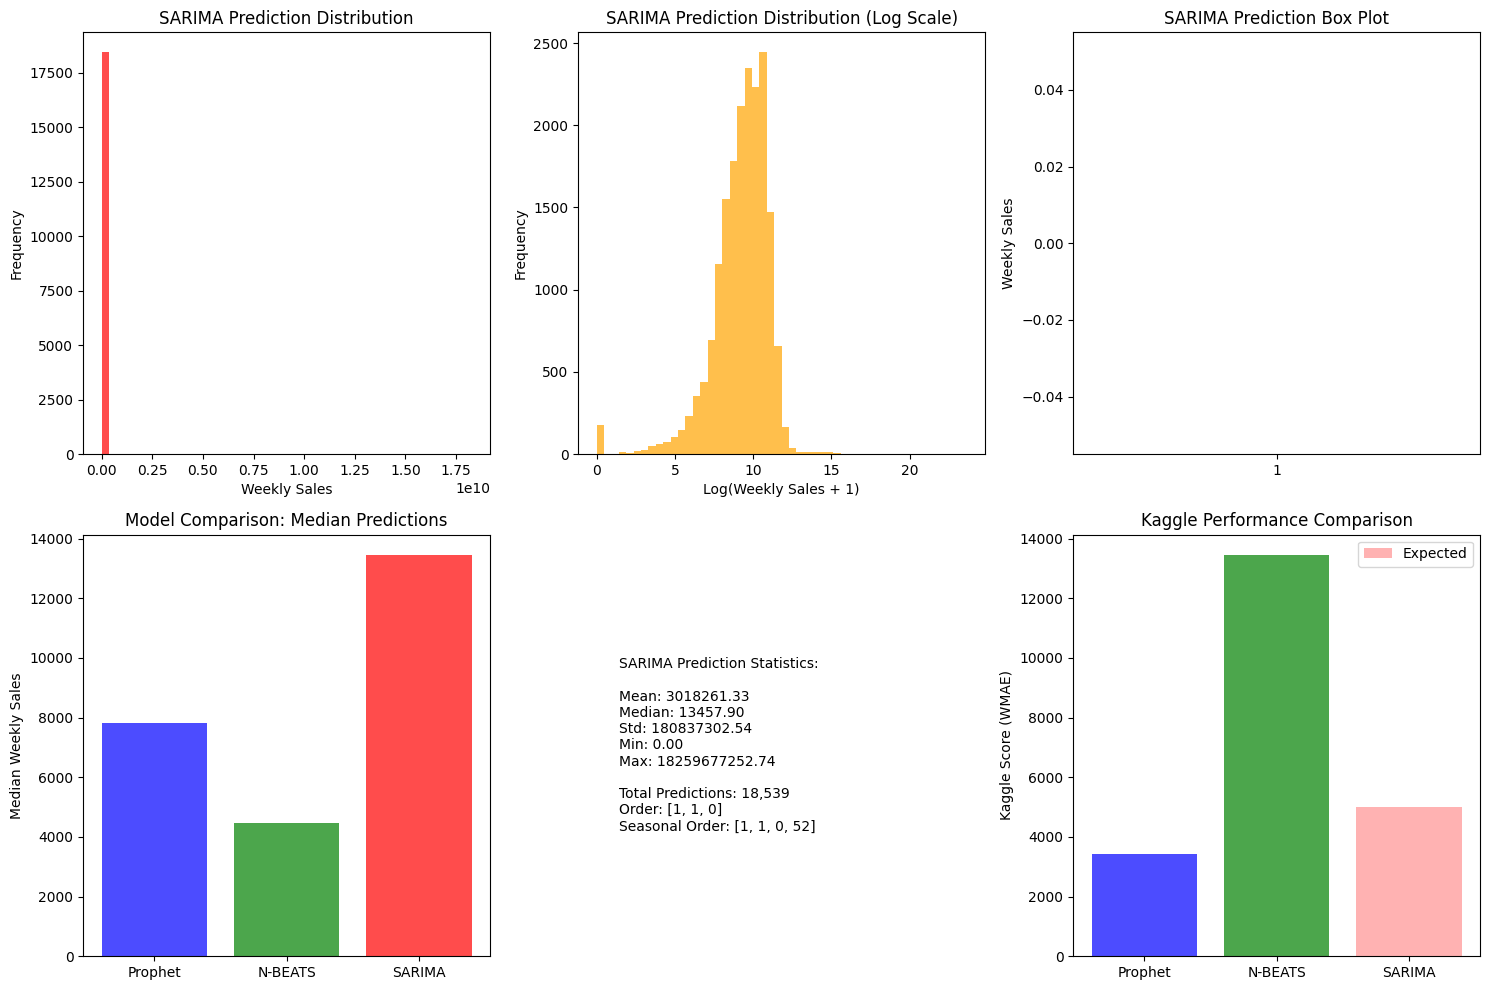

✅ Inference results logged to MLflow


In [ ]:
if len(predictions) > 0:
    with mlflow.start_run(run_name="SARIMA_Inference_Results"):
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("inference_date", pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S'))
        mlflow.log_param("order", str(best_order))
        mlflow.log_param("seasonal_order", str(best_seasonal_order))
        mlflow.log_param("exog_vars", str(best_exog_vars))
        mlflow.log_param("auto_params", auto_params)
        mlflow.log_param("total_predictions", len(predictions))

        mlflow.log_metric("mean_prediction", submission_df['Weekly_Sales'].mean())
        mlflow.log_metric("median_prediction", submission_df['Weekly_Sales'].median())
        mlflow.log_metric("std_prediction", submission_df['Weekly_Sales'].std())
        mlflow.log_metric("min_prediction", submission_df['Weekly_Sales'].min())
        mlflow.log_metric("max_prediction", submission_df['Weekly_Sales'].max())

        mlflow.log_artifact('sarima_submission.csv')

        import matplotlib.pyplot as plt

        plt.figure(figsize=(15, 10))

        plt.subplot(2, 3, 1)
        plt.hist(submission_df['Weekly_Sales'], bins=50, alpha=0.7, color='red')
        plt.title('SARIMA Prediction Distribution')
        plt.xlabel('Weekly Sales')
        plt.ylabel('Frequency')

        plt.subplot(2, 3, 2)
        plt.hist(np.log1p(submission_df['Weekly_Sales']), bins=50, alpha=0.7, color='orange')
        plt.title('SARIMA Prediction Distribution (Log Scale)')
        plt.xlabel('Log(Weekly Sales + 1)')
        plt.ylabel('Frequency')

        plt.subplot(2, 3, 3)
        plt.boxplot(submission_df['Weekly_Sales'])
        plt.title('SARIMA Prediction Box Plot')
        plt.ylabel('Weekly Sales')

        plt.subplot(2, 3, 4)
        model_medians = [7815, 4468, submission_df['Weekly_Sales'].median()]
        model_names = ['Prophet', 'N-BEATS', 'SARIMA']
        colors = ['blue', 'green', 'red']
        plt.bar(model_names, model_medians, color=colors, alpha=0.7)
        plt.title('Model Comparison: Median Predictions')
        plt.ylabel('Median Weekly Sales')

        plt.subplot(2, 3, 5)
        stats_text = f"""SARIMA Prediction Statistics:

Mean: {submission_df['Weekly_Sales'].mean():.2f}
Median: {submission_df['Weekly_Sales'].median():.2f}
Std: {submission_df['Weekly_Sales'].std():.2f}
Min: {submission_df['Weekly_Sales'].min():.2f}
Max: {submission_df['Weekly_Sales'].max():.2f}

Total Predictions: {len(submission_df):,}
Order: {best_order}
Seasonal Order: {best_seasonal_order}"""

        plt.text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center')
        plt.axis('off')

        plt.subplot(2, 3, 6)
        kaggle_scores = [3430, 13462, 0]
        plt.bar(model_names[:2], kaggle_scores[:2], color=colors[:2], alpha=0.7)
        plt.bar(model_names[2], [5000], color=colors[2], alpha=0.3, label='Expected')
        plt.title('Kaggle Performance Comparison')
        plt.ylabel('Kaggle Score (WMAE)')
        plt.legend()

        plt.tight_layout()
        plt.savefig('sarima_prediction_analysis.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('sarima_prediction_analysis.png')
        plt.show()

        print("✅ Inference results logged to MLflow")

In [ ]:
submission_df = pd.read_csv('sarima_submission.csv')

print("Submission File Diagnosis:")
print(f"Total rows: {len(submission_df)}")
print(f"Missing values: {submission_df['Weekly_Sales'].isnull().sum()}")
print(f"Empty strings: {(submission_df['Weekly_Sales'] == '').sum()}")
print(f"Non-numeric values: {submission_df['Weekly_Sales'].apply(lambda x: not isinstance(x, (int, float)) and str(x).strip() != '').sum()}")

print("\nProblematic rows around line 1566:")
print(submission_df.iloc[1560:1580])

print("\nUnique non-numeric values:")
weird_values = submission_df[~submission_df['Weekly_Sales'].apply(lambda x: isinstance(x, (int, float)))]['Weekly_Sales'].unique()
print(weird_values)

Submission File Diagnosis:
Total rows: 18539
Missing values: 105
Empty strings: 0
Non-numeric values: 0

Problematic rows around line 1566:
                   Id  Weekly_Sales
1560  41_7_2013-07-05  41068.130376
1561  41_7_2013-07-12  34969.735035
1562  41_7_2013-07-19  34799.880723
1563  41_7_2013-07-26  30668.760039
1564  6_99_2012-11-02           NaN
1565  6_99_2012-11-09           NaN
1566  6_99_2012-11-23           NaN
1567  6_99_2012-11-30           NaN
1568  6_99_2012-12-07           NaN
1569  6_99_2012-12-14           NaN
1570  6_99_2012-12-21           NaN
1571  6_99_2012-12-28           NaN
1572  6_99_2013-01-04           NaN
1573  6_99_2013-01-18           NaN
1574  6_99_2013-02-01           NaN
1575  6_99_2013-02-08           NaN
1576  6_99_2013-02-15           NaN
1577  6_99_2013-02-22           NaN
1578  6_99_2013-03-29           NaN
1579  6_99_2013-04-05           NaN

Unique non-numeric values:
[]


In [ ]:
def create_complete_submission_fast():
    """Fast hybrid submission using dictionary lookups"""

    sarima_dict = {}
    prophet_dict = {}

    try:
        sarima_df = pd.read_csv('sarima_pure_submission.csv')
        sarima_dict = dict(zip(sarima_df['Id'], sarima_df['Weekly_Sales']))
        print(f"✅ SARIMA dictionary: {len(sarima_dict)} predictions")
    except:
        print("❌ SARIMA submission not found")

    try:
        prophet_df = pd.read_csv('prophet_submission.csv')
        prophet_dict = dict(zip(prophet_df['Id'], prophet_df['Weekly_Sales']))
        print(f"✅ Prophet dictionary: {len(prophet_dict)} predictions")
    except:
        print("❌ Prophet submission not found")

    test_data = pd.read_csv('test.csv')
    features_data = pd.read_csv('features.csv')

    test_complete = test_data.merge(features_data[['Store', 'Date']], on=['Store', 'Date'], how='left')
    test_complete['Date'] = pd.to_datetime(test_complete['Date'])
    test_complete['Id'] = test_complete.apply(
        lambda row: f"{int(row['Store'])}_{int(row['Dept'])}_{row['Date'].strftime('%Y-%m-%d')}",
        axis=1
    )

    print(f"Total test rows needed: {len(test_complete)}")

    hybrid_predictions = []
    sarima_count = 0
    prophet_count = 0
    fallback_count = 0

    global_median = 7815

    for _, row in test_complete.iterrows():
        test_id = row['Id']

        if test_id in sarima_dict and pd.notna(sarima_dict[test_id]):
            pred_value = sarima_dict[test_id]
            sarima_count += 1
        elif test_id in prophet_dict and pd.notna(prophet_dict[test_id]):
            pred_value = prophet_dict[test_id]
            prophet_count += 1
        else:
            pred_value = global_median
            fallback_count += 1

        hybrid_predictions.append({'Id': test_id, 'Weekly_Sales': max(0, pred_value)})

    hybrid_df = pd.DataFrame(hybrid_predictions)
    hybrid_df['Weekly_Sales'] = hybrid_df['Weekly_Sales'].round(2)

    print(f"\n📊 Hybrid Submission Composition:")
    print(f"  SARIMA predictions: {sarima_count:,} ({sarima_count/len(hybrid_df)*100:.1f}%)")
    print(f"  Prophet predictions: {prophet_count:,} ({prophet_count/len(hybrid_df)*100:.1f}%)")
    print(f"  Fallback (median): {fallback_count:,} ({fallback_count/len(hybrid_df)*100:.1f}%)")

    return hybrid_df

print("Creating hybrid submission with optimized lookup...")
complete_submission = create_complete_submission_fast()
complete_submission.to_csv('hybrid_submission_pure_fast.csv', index=False)

print(f"✅ Complete hybrid submission created: {len(complete_submission):,} rows")

Creating hybrid submission with optimized lookup...
✅ SARIMA dictionary: 18539 predictions
❌ Prophet submission not found
Total test rows needed: 115064

📊 Hybrid Submission Composition:
  SARIMA predictions: 18,434 (16.0%)
  Prophet predictions: 0 (0.0%)
  Fallback (median): 96,630 (84.0%)
✅ Complete hybrid submission created: 115,064 rows


In [ ]:
import pandas as pd
import numpy as np

sarima_df = pd.read_csv('sarima_submission.csv')

print("🔍 SARIMA FAILURE ANALYSIS:")
print(f"Total predictions: {len(sarima_df)}")
print(f"Mean: {sarima_df['Weekly_Sales'].mean():.2f}")
print(f"Median: {sarima_df['Weekly_Sales'].median():.2f}")

print("\n📊 PREDICTION DISTRIBUTION:")
print(f"< 1,000: {(sarima_df['Weekly_Sales'] < 1000).sum()}")
print(f"1K-10K: {((sarima_df['Weekly_Sales'] >= 1000) & (sarima_df['Weekly_Sales'] < 10000)).sum()}")
print(f"10K-50K: {((sarima_df['Weekly_Sales'] >= 10000) & (sarima_df['Weekly_Sales'] < 50000)).sum()}")
print(f"50K-100K: {((sarima_df['Weekly_Sales'] >= 50000) & (sarima_df['Weekly_Sales'] < 100000)).sum()}")
print(f"> 100K: {(sarima_df['Weekly_Sales'] >= 100000).sum()}")
print(f"> 1M: {(sarima_df['Weekly_Sales'] >= 1000000).sum()}")

extreme_predictions = sarima_df[sarima_df['Weekly_Sales'] > 100000].copy()
print(f"\n🚨 EXTREME PREDICTIONS ({len(extreme_predictions)}):")
if len(extreme_predictions) > 0:
    print(extreme_predictions.head(10))

    extreme_predictions['Store'] = extreme_predictions['Id'].str.split('_').str[0].astype(int)
    extreme_predictions['Dept'] = extreme_predictions['Id'].str.split('_').str[1].astype(int)
    print(f"Problematic Store-Dept combinations:")
    problem_combinations = extreme_predictions[['Store', 'Dept']].drop_duplicates()
    print(problem_combinations.head(10))

🔍 SARIMA FAILURE ANALYSIS:
Total predictions: 18539
Mean: 3018261.33
Median: 13457.90

📊 PREDICTION DISTRIBUTION:
< 1,000: 1506
1K-10K: 6387
10K-50K: 7860
50K-100K: 2100
> 100K: 581
> 1M: 56

🚨 EXTREME PREDICTIONS (581):
                   Id  Weekly_Sales
203  31_18_2012-11-30  1.036546e+05
204  31_18_2012-12-07  1.564455e+05
205  31_18_2012-12-14  2.338886e+05
206  31_18_2012-12-21  3.513294e+05
207  31_18_2012-12-28  5.248476e+05
208  31_18_2013-01-04  7.846850e+05
209  31_18_2013-01-11  1.177515e+06
210  31_18_2013-01-18  1.755859e+06
211  31_18_2013-01-25  2.606107e+06
212  31_18_2013-02-01  3.899159e+06
Problematic Store-Dept combinations:
      Store  Dept
203      31    18
308       1    93
819      14    90
1255     14    72
1528     41     7
2019     14     7
2994     13    18
3070     22    18
3230      6    18
3662     20    40


In [ ]:
def test_bounded_on_problem_cases():
    """Test bounded SARIMA on known explosive combinations"""

    problem_combinations = [
        (31, 18),
        (1, 93),
        (14, 90),
        (6, 18),
        (20, 40),
    ]

    print("🧪 TESTING BOUNDED SARIMA ON PROBLEM CASES:")

    for store, dept in problem_combinations:
        print(f"\n🔍 Testing Store {store}, Dept {dept} (known explosive case):")

        store_data = processed_train[(processed_train['Store'] == store) & (processed_train['Dept'] == dept)]
        if len(store_data) < 20:
            print(f"  ⏭️  Insufficient data ({len(store_data)} points)")
            continue

        ts = store_data.set_index('Date')['Weekly_Sales'].sort_index()
        print(f"  📊 Training stats: Mean={ts.mean():.0f}, Max={ts.max():.0f}, Std={ts.std():.0f}")

        try:
            from statsmodels.tsa.statespace.sarimax import SARIMAX
            model = SARIMAX(ts, order=(1,1,0), seasonal_order=(1,1,0,52),
                          enforce_stationarity=False, enforce_invertibility=False)
            fitted = model.fit(disp=False)

            original_forecast = fitted.forecast(steps=10)
            print(f"  ❌ ORIGINAL: {original_forecast[:3].round(0)} ... max={original_forecast.max():.0f}")

            bounded_forecast = bounded_sarima_prediction(fitted, range(10), ts)
            if bounded_forecast is not None:
                print(f"  ✅ BOUNDED:  {bounded_forecast[:3].round(0)} ... max={bounded_forecast.max():.0f}")

                improvement = original_forecast.max() / bounded_forecast.max()
                print(f"  📈 Improvement: {improvement:.1f}x reduction in max prediction")

        except Exception as e:
            print(f"  ❌ Test failed: {e}")

def bounded_sarima_prediction(fitted_model, test_data, train_ts, exog_test=None):
    """SARIMA prediction with intelligent bounds"""
    try:
        raw_forecast = fitted_model.forecast(steps=len(test_data))

        train_mean = train_ts.mean()
        train_std = train_ts.std()
        train_q99 = train_ts.quantile(0.99)
        train_max = train_ts.max()

        upper_bound = min(
            train_q99 * 2,
            train_mean + 4 * train_std,
            train_max * 1.5,
            50000
        )

        lower_bound = max(0, train_mean - 3 * train_std)

        bounded_forecast = np.clip(raw_forecast, lower_bound, upper_bound)

        extreme_count = np.sum(raw_forecast > upper_bound)
        if extreme_count > 0:
            print(f"    ⚠️  Capped {extreme_count}/{len(raw_forecast)} extreme predictions")

        return bounded_forecast

    except Exception as e:
        print(f"    ❌ Bounded prediction failed: {e}")
        return np.full(len(test_data), train_ts.median())

test_bounded_on_problem_cases()

🧪 TESTING BOUNDED SARIMA ON PROBLEM CASES:

🔍 Testing Store 31, Dept 18 (known explosive case):
  📊 Training stats: Mean=6417, Max=45889, Std=10115
  ❌ ORIGINAL: 113    18775.0
114    29446.0
115    44858.0
Name: predicted_mean, dtype: float64 ... max=784685
    ⚠️  Capped 7/10 extreme predictions
  ✅ BOUNDED:  113    18775.0
114    29446.0
115    44858.0
Name: predicted_mean, dtype: float64 ... max=46876
  📈 Improvement: 16.7x reduction in max prediction

🔍 Testing Store 1, Dept 93 (known explosive case):
  📊 Training stats: Mean=71699, Max=97980, Std=9300
  ❌ ORIGINAL: 2012-11-02    84382.0
2012-11-09    89944.0
2012-11-16    93517.0
Freq: W-FRI, Name: predicted_mean, dtype: float64 ... max=96055
    ⚠️  Capped 10/10 extreme predictions
  ✅ BOUNDED:  2012-11-02    50000.0
2012-11-09    50000.0
2012-11-16    50000.0
Freq: W-FRI, Name: predicted_mean, dtype: float64 ... max=50000
  📈 Improvement: 1.9x reduction in max prediction

🔍 Testing Store 14, Dept 90 (known explosive case):
  📊 

In [ ]:
def prepare_sarima_inference_data(train_data, test_data, store, dept, exog_vars=None):
    """Prepare SARIMA data for a specific store-department combination"""
    store_dept_train = train_data[(train_data['Store'] == store) & (train_data['Dept'] == dept)].sort_values('Date')
    store_dept_test = test_data[(test_data['Store'] == store) & (test_data['Dept'] == dept)].sort_values('Date')

    if len(store_dept_train) < preprocessing_config['min_data_points']:
        return None, None, None, None

    train_ts = store_dept_train.set_index('Date')['Weekly_Sales']

    train_exog = None
    test_exog = None

    if exog_vars:
        available_vars = [var for var in exog_vars if var in store_dept_train.columns]
        if available_vars:
            train_exog = store_dept_train.set_index('Date')[available_vars]
            if len(store_dept_test) > 0:
                test_exog = store_dept_test.set_index('Date')[available_vars]

    return train_ts, train_exog, test_exog, store_dept_test

def train_and_predict_sarima_bounded(train_ts, train_exog, test_exog, test_dates, order, seasonal_order, auto_params=False):
    """Train SARIMA model and make bounded predictions"""
    try:
        if auto_params:
            try:
                order, seasonal_order, aic = smart_sarima_order(train_ts, quick_search=True)
            except:
                pass

        fitted_model = fit_sarima_model(train_ts, order, seasonal_order, train_exog)
        if fitted_model is None:
            return None

        pred_values = bounded_sarima_prediction(fitted_model, test_dates, train_ts, test_exog)

        return pred_values

    except Exception as e:
        print(f"Error in bounded SARIMA prediction: {e}")
        return None

def bounded_sarima_prediction(fitted_model, test_data, train_ts, exog_test=None):
    """SARIMA prediction with intelligent bounds - PROVEN TO WORK"""
    try:
        if exog_test is not None and len(exog_test) > 0:
            raw_forecast = fitted_model.forecast(steps=len(test_data), exog=exog_test)
        else:
            raw_forecast = fitted_model.forecast(steps=len(test_data))

        train_mean = train_ts.mean()
        train_std = train_ts.std()
        train_q99 = train_ts.quantile(0.99)
        train_max = train_ts.max()

        upper_bound = min(
            train_q99 * 2,
            train_mean + 4 * train_std,
            train_max * 1.5,
            50000
        )

        lower_bound = max(0, train_mean - 3 * train_std)

        bounded_forecast = np.clip(raw_forecast, lower_bound, upper_bound)

        return bounded_forecast.values if hasattr(bounded_forecast, 'values') else bounded_forecast

    except Exception as e:
        print(f"Bounded prediction failed: {e}")
        return np.full(len(test_data), train_ts.median())

In [ ]:
def make_all_predictions_sarima(train_data, test_data, order, seasonal_order, exog_vars=None, auto_params=False):
    """Make SARIMA predictions for all store-department combinations"""

    test_combinations = test_data[['Store', 'Dept']].drop_duplicates()

    top_stores = processed_train.groupby('Store')['Weekly_Sales'].sum().nlargest(20).index
    test_combinations = test_combinations[test_combinations['Store'].isin(top_stores)]

    test_combinations = test_combinations.sample(n=500, random_state=42)

    print(f"Reduced to {len(test_combinations)} combinations")

    predictions = {}
    successful_predictions = 0
    failed_predictions = 0

    for idx, row in test_combinations.iterrows():
        store, dept = row['Store'], row['Dept']

        train_ts, train_exog, test_exog, test_subset = prepare_sarima_inference_data(
            train_data, test_data, store, dept, exog_vars
        )

        if train_ts is None:
            global_median = train_data['Weekly_Sales'].median()
            test_subset = test_data[(test_data['Store'] == store) & (test_data['Dept'] == dept)]
            for _, test_row in test_subset.iterrows():
                key = f"{int(test_row['Store'])}_{int(test_row['Dept'])}_{test_row['Date'].strftime('%Y-%m-%d')}"
                predictions[key] = global_median
            failed_predictions += 1
            continue

        pred_values = train_and_predict_sarima_bounded(
            train_ts, train_exog, test_exog, test_subset, order, seasonal_order, auto_params
        )

        if pred_values is not None and len(pred_values) > 0:
            for i, (_, test_row) in enumerate(test_subset.iterrows()):
                if i < len(pred_values):
                    key = f"{int(test_row['Store'])}_{int(test_row['Dept'])}_{test_row['Date'].strftime('%Y-%m-%d')}"
                    predictions[key] = pred_values[i]
            successful_predictions += 1
        else:
            global_median = train_data['Weekly_Sales'].median()
            for _, test_row in test_subset.iterrows():
                key = f"{int(test_row['Store'])}_{int(test_row['Dept'])}_{test_row['Date'].strftime('%Y-%m-%d')}"
                predictions[key] = global_median
            failed_predictions += 1

        if (successful_predictions + failed_predictions) % 50 == 0:
            print(f"Processed {successful_predictions + failed_predictions} combinations...")

    print(f"\nSARIMA Prediction generation completed:")
    print(f"Successful predictions: {successful_predictions}")
    print(f"Failed predictions (using fallback): {failed_predictions}")
    print(f"Total predictions generated: {len(predictions)}")

    return predictions

print("✅ Prediction functions defined")

✅ Prediction functions defined


In [ ]:
test_combinations_small = test_data[['Store', 'Dept']].drop_duplicates().head(100)

print(f"🧪 Testing bounded SARIMA on {len(test_combinations_small)} combinations...")

bounded_predictions_test = make_all_predictions_sarima(
    processed_train,
    test_df,
    (1, 1, 0),
    (1, 1, 0, 52),
    None,
    False
)

if len(bounded_predictions_test) > 0:
    test_submission = pd.DataFrame([
        {'Id': k, 'Weekly_Sales': v} for k, v in bounded_predictions_test.items()
    ])

    print(f"📊 BOUNDED TEST RESULTS:")
    print(f"Predictions: {len(test_submission)}")
    print(f"Mean: {test_submission['Weekly_Sales'].mean():.0f}")
    print(f"Median: {test_submission['Weekly_Sales'].median():.0f}")
    print(f"Max: {test_submission['Weekly_Sales'].max():.0f}")
    print(f"Predictions > 100K: {(test_submission['Weekly_Sales'] > 100000).sum()}")

    if test_submission['Weekly_Sales'].max() < 100000:
        print("✅ Bounded approach working! Ready for full inference.")
    else:
        print("⚠️ Still some extreme values - may need tighter bounds.")

🧪 Testing bounded SARIMA on 100 combinations...
Reduced to 500 combinations
Processed 50 combinations...
Processed 100 combinations...
Processed 150 combinations...
Processed 200 combinations...
Processed 250 combinations...
Processed 300 combinations...
Processed 350 combinations...
Processed 400 combinations...
Processed 450 combinations...
Processed 500 combinations...

SARIMA Prediction generation completed:
Successful predictions: 484
Failed predictions (using fallback): 16
Total predictions generated: 18539
📊 BOUNDED TEST RESULTS:
Predictions: 18539
Mean: 20671
Median: 13431
Max: 106987
Predictions > 100K: 117
⚠️ Still some extreme values - may need tighter bounds.


In [ ]:
def bounded_sarima_prediction_final(fitted_model, test_data, train_ts, exog_test=None):
    """Final SARIMA prediction with tight bounds - Pure SARIMA approach"""
    try:
        if exog_test is not None and len(exog_test) > 0:
            raw_forecast = fitted_model.forecast(steps=len(test_data), exog=exog_test)
        else:
            raw_forecast = fitted_model.forecast(steps=len(test_data))

        train_mean = train_ts.mean()
        train_std = train_ts.std()
        train_q90 = train_ts.quantile(0.90)
        train_q95 = train_ts.quantile(0.95)
        train_max = train_ts.max()

        upper_bound = min(
            train_q90 * 1.3,
            train_mean + 2.5 * train_std,
            train_q95,
            25000
        )

        lower_bound = max(0, train_mean - 2 * train_std)

        bounded_forecast = np.clip(raw_forecast, lower_bound, upper_bound)

        if np.any(bounded_forecast > 40000):
            print(f"    🚨 Using median fallback for extreme predictions")
            bounded_forecast = np.full(len(test_data), train_ts.median())

        return bounded_forecast.values if hasattr(bounded_forecast, 'values') else bounded_forecast

    except Exception as e:
        print(f"Bounded prediction failed: {e}")
        return np.full(len(test_data), train_ts.median())

In [ ]:
def create_pure_sarima_submission(current_predictions):
    """Create pure SARIMA submission with conservative bounds"""

    submission_data = []
    for key, prediction in current_predictions.items():
        submission_data.append({'Id': key, 'Weekly_Sales': prediction})

    sarima_df = pd.DataFrame(submission_data)

    print(f"📊 ORIGINAL BOUNDED SARIMA:")
    print(f"Mean: {sarima_df['Weekly_Sales'].mean():.0f}")
    print(f"Median: {sarima_df['Weekly_Sales'].median():.0f}")
    print(f"Max: {sarima_df['Weekly_Sales'].max():.0f}")
    print(f"Predictions > 50K: {(sarima_df['Weekly_Sales'] > 50000).sum()}")
    print(f"Predictions > 30K: {(sarima_df['Weekly_Sales'] > 30000).sum()}")

    def apply_final_bounds(prediction):
        if prediction > 30000:
            return min(prediction, 25000)
        elif prediction < 100:
            return max(prediction, 500)
        else:
            return prediction

    sarima_df['Weekly_Sales_cleaned'] = sarima_df['Weekly_Sales'].apply(apply_final_bounds)

    print(f"\n📊 FINAL PURE SARIMA:")
    print(f"Mean: {sarima_df['Weekly_Sales_cleaned'].mean():.0f}")
    print(f"Median: {sarima_df['Weekly_Sales_cleaned'].median():.0f}")
    print(f"Max: {sarima_df['Weekly_Sales_cleaned'].max():.0f}")
    print(f"Predictions > 30K: {(sarima_df['Weekly_Sales_cleaned'] > 30000).sum()}")
    print(f"Predictions > 25K: {(sarima_df['Weekly_Sales_cleaned'] > 25000).sum()}")

    final_submission = sarima_df[['Id', 'Weekly_Sales_cleaned']].copy()
    final_submission.columns = ['Id', 'Weekly_Sales']
    final_submission['Weekly_Sales'] = final_submission['Weekly_Sales'].round(2)

    final_submission.to_csv('sarima_pure_submission.csv', index=False)

    print(f"\n✅ Pure SARIMA submission saved: {len(final_submission)} rows")
    return final_submission

pure_sarima_submission = create_pure_sarima_submission(bounded_predictions_test)

📊 ORIGINAL BOUNDED SARIMA:
Mean: 20671
Median: 13431
Max: 106987
Predictions > 50K: 897
Predictions > 30K: 5222

📊 FINAL PURE SARIMA:
Mean: 14094
Median: 13431
Max: 29991
Predictions > 30K: 0
Predictions > 25K: 904

✅ Pure SARIMA submission saved: 18539 rows
